# PROJECT FAME

**Problem**: Forecasting from early time well production leads to non-unique estimates of ultimate reserves. The production history required to qualify a forecast as confident is loosely defined.

**Hypthesis**: An accuracy score be used to relate the volume of production history to forecast confidence under different sets of conditions.

# WORK PLAN

1. Create synthetic forecasts
    - Exponential decline
    - Arps b=0.5, b~1.0, b=1.5
    - Irregular production case

2. Test different volume sampling periods
    - Daily data
    - Monthly data

3. Add error to the forecast
    - Zero error
    - Low error (how TBD)
    - Medium error
    - High error

4. At different time horizons ...
    - Bootstrap 100 realizations of the prior production history
        - *complication*: production history broadly declines as the result of 
           withdraw, the window size for each boostrapped sample will need to 
           be small or some bias needs to be introduced on the boostrap.
    - For each boostrap, regress an ARPs decline and calculate EUR from the
       forecast.
    - Caclulate accuracy score

5. Summarize findings.

# EXAMPLE OF ONE ITERATION

In [23]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from matplotlib.ticker import StrMethodFormatter
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore', category=UserWarning)

golden_ratio = (1 + 5 ** 0.5) / 2

In [2]:
class ground_truth:
    """
    Class to generate ground truth data for a given set of parameters.

    Parameters:
    qi: Initial production rate, bopd
    di: Initial decline rate, effective annual
    b: Decline exponent
    dmin: Minimum decline rate, effective annual
    qab: Abandonment rate, bopd
    scale: Time scale, 'month' or 'day'
    """
    def __init__(self, qi, di, b, dmin, qab, scale):
        self.qi = qi
        self.di = di
        self.b = b
        self.dmin = dmin
        self.qab = qab
        self.scale = scale
        self.scalar = 365 if scale == 'day' else 12
        self.t = np.arange(0, 100 * self.scalar, 1)
        self.rate = self.calc_modified_arps(qi=self.qi, di=self.di, b=self.b, dmin=self.dmin, qab=self.qab)
        self.cum = np.cumsum(self.rate)
        self.eur = np.max(self.cum)
        self.confidence_intervals = [5,10,15,20,25,30,35,40,45,50]
    
    def calc_modified_arps(self, qi=None, di=None, b=None, dmin=None, qab=None):
        """
        Calculate a modified ARPS decline with a terminal exponential 
        decline and an abandonment rate.
        
        Parameters:
        - qi: Initial production rate, bopd
        - di: Initial decline rate, effecitve annual
        - b: b-factor
        - dmin: Minimum decline rate, effective annual
        - r_abandon: Abandonment rate, bopd
        
        Returns:
        - Production rate at time t
        """
        t = self.t
        D_tangent = ((1 - di) ** (-b) - 1) / b
        D_terminal = -1 * np.log(1 - dmin)
        q_terminal = qi * (D_terminal / D_tangent) ** (1 / b)
        t_terminal = ((qi / q_terminal) ** b - 1) / (b * D_tangent / self.scalar)

        x = np.zeros(len(t))
        mask = t < t_terminal
        x[mask] = qi * (1 + b * (D_tangent / self.scalar) * t[mask]) ** (-1 / b)
        x[~mask] = q_terminal * np.exp(-1 * (D_terminal / self.scalar) * (t[~mask] - t_terminal))
        x[x < qab] = 0

        return x

    def add_error(self, error_pct):
        """
        Add normally distributed error to the production rate.
        
        Parameters:
        - error: Standard deviation of the error distribution

        Returns:
        - rate_error: Production rate with error
        """
        self.rate_error = self.rate * (1 + np.random.normal(0, error_pct / 100, len(self.t)))
        self.cum_error = np.cumsum(self.rate_error)
        self.eur_error = np.max(self.cum_error)
    
    def bootstrap(self, iterations, window):
        """
        Bootstrap the simulated data to generate a distribution of EURs.
        
        Parameters:
        - iterations: Number of bootstrap iterations to perform
        - window: Length of the bootstrap window

        Returns:
        - bootstrap_array: Array of bootstrapped production rates
        """
        split_array = np.array_split(self.rate_error, len(self.rate_error) // window)
        bootstrap_array = np.zeros(shape=(iterations, len(self.rate_error)))
        for i in range(iterations):
            boot_strap = split_array.copy()
            for j, w in enumerate(split_array):
                boot_strap[j] = np.random.choice(w, size=len(w), replace=True)
            bootstrap_array[i, :] = np.concatenate(boot_strap)
        self.bootstrap_array = bootstrap_array
    
    def regress_forecast(self, params, history):
        """
        Calculate forecasts and return MSE for the minimizer.
        
        Paramters:
        - params: List of parameters to optimize

        Returns:
        - mse: Mean squared error between the forecast and the history
        """
        di, b = params
        forecast = self.calc_modified_arps(qi=self.qi, di=di, b=b, dmin=self.dmin, qab=self.qab)
        mse = np.sum((forecast[:len(history)] - history) ** 2)
        return mse

    
    def calc_bootsrap_forecasts(self, time_increments, max_windows, initial, bounds):
        """
        Calculate forecasts for each bootstrap iteration using an expanding
        window the size of the time increments.

        Parameters:
        - time_increments: Size of the expanding window
        - max_windows: Maximum number of expanding windows to calculate
        - initial: Initial guess for the minimizer [di, b]
        - bounds: [(di_min, di_max), (b_min, b_max))]

        Returns: Array of EURs for each bootstrap iteration and window_size.
                    [bootstrap_iterations, time_increments]
        """
        expanding_windows = np.arange(time_increments, (time_increments + 1) * max_windows, time_increments)
        iterations = self.bootstrap_array.shape[0]
        eur_array = np.zeros(shape=(iterations, len(expanding_windows)))
        for i in range(iterations):
            for j, w in enumerate(expanding_windows):
                history = self.bootstrap_array[i, :w]
                match_di, match_b = minimize(self.regress_forecast, 
                                             x0=initial, 
                                             args=(history), 
                                             bounds=bounds).x
                forecast = self.calc_modified_arps(qi=self.qi, di=match_di, b=match_b, dmin=self.dmin, qab=self.qab)
                eur = np.max(np.cumsum(forecast))
                eur_array[i, j] = eur
        self.eur_array = eur_array

    def score_prediction(self):
        """
        Calculate whether or not the actual EUR is within a range of confidence 
        intervals.

        Returns: Array of 1s and 0s for each confidence interval and bootstrap 
                    iteration. [confidence_intervals, time_increments]
                 
        """
        confidence_intervals = self.confidence_intervals
        score_array = np.zeros([len(confidence_intervals), self.eur_array.shape[1]])
        for i, interval in enumerate(confidence_intervals):
            for j in range(self.eur_array.shape[1]):
                lower = np.percentile(self.eur_array[:, j], 50 - interval)
                upper = np.percentile(self.eur_array[:, j], 50 + interval)
                if self.eur > lower and self.eur < upper:
                    score_array[i, j] = 1
                else:    
                    score_array[i, j] = 0
        self.score_array = score_array

    ## TODO: Add a function to determin if the forecasted values are withini the bounds of a confedence interval


In [3]:
pass

In [4]:
# create a test instance of the well object and add error to the production rate
test = ground_truth(1000, 0.82, 1.2, 0.07, 1, 'day')
test.add_error(10)

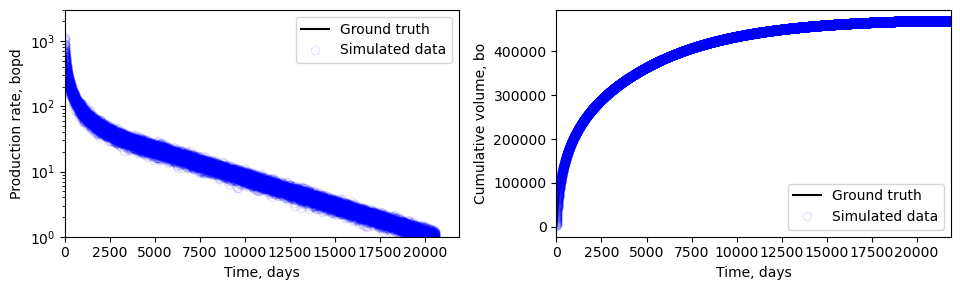

In [5]:
# plot the production rate and cumulative production with error for the test instance
fig, axs = plt.subplots(ncols=2, figsize=(golden_ratio * 3 * 2, 3))
axs[0].plot(test.t, test.rate, 'k-', label='Ground truth')
axs[0].plot(test.t, test.rate_error, 'o', c='none', mec='b', alpha=0.1, label='Simulated data')
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 60), ylim=(1, 3000))
axs[0].legend(loc='upper right')
axs[1].plot(test.t, test.cum, 'k-', label='Ground truth')
axs[1].plot(test.t, test.cum_error, 'o', c='none', mec='b', alpha=0.1, label='Simulated data')
axs[1].set(xlabel='Time, days', ylabel='Cumulative volume, bo', xlim=(0,365*60))
axs[1].legend(loc='lower right')
plt.tight_layout(); plt.show()

In [6]:
# create the bootstrap array for the test instance
test.bootstrap(iterations=100, 
               window=10)

In [7]:
# calculate forecasts for bootstrap iterations and different expanding windows
test.calc_bootsrap_forecasts(time_increments=30,
                             max_windows=20,
                             initial=[0.75, 1.0001],
                             bounds=[(0.5, 0.99), (0.5, 1.5)])

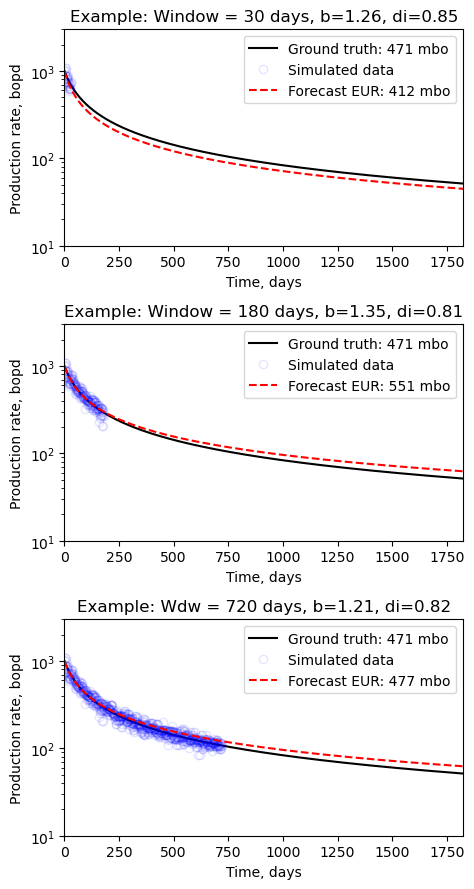

In [8]:
# create some forecast visuals
def calculate_single_bootsrap_fit(boot_strap_iteration, window_max, initial, bounds):
    history = test.bootstrap_array[boot_strap_iteration, :window_max]
    match_di, match_b = minimize(test.regress_forecast, 
                                    x0=initial, 
                                    args=(history), 
                                    bounds=bounds).x
    forecast = test.calc_modified_arps(qi=test.qi, di=match_di, b=match_b, dmin=test.dmin, qab=test.qab)
    return forecast, match_di, match_b

boot_strap_iteration = 10
bounds = [(0.5, 0.99), (0.5, 1.5)]
initial_guess = [0.75, 1.001]

# 30 day example
window_1 = 30
forecast_1, match_di_1, match_b_1 = calculate_single_bootsrap_fit(boot_strap_iteration, window_1, initial_guess, bounds)

# 180 day example
window_2 = 180
forecast_2, match_di_2, match_b_2 = calculate_single_bootsrap_fit(boot_strap_iteration, window_2, initial_guess, bounds)

# 720 day example
window_3 = 720
forecast_3, match_di_3, match_b_3 = calculate_single_bootsrap_fit(boot_strap_iteration, window_3, initial_guess, bounds)

# plot the examples
fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(golden_ratio * 3, 3 * 3))

axs[0].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
axs[0].plot(range(0,window_1), test.bootstrap_array[boot_strap_iteration, :window_1], 
            'o', c='none', mec='b', alpha=0.1, label='Simulated data')
axs[0].plot(test.t, forecast_1, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_1))/1000:.0f} mbo')
axs[0].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
           title=f'Example: Window = 30 days, b={match_b_1:.2f}, di={match_di_1:.2f}')
axs[0].legend(loc='upper right')

axs[1].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
axs[1].plot(range(0,window_2), test.bootstrap_array[boot_strap_iteration, :window_2], 
            'o', c='none', mec='b', alpha=0.1, label='Simulated data')
axs[1].plot(test.t, forecast_2, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_2))/1000:.0f} mbo')
axs[1].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
           title=f'Example: Window = 180 days, b={match_b_2:.2f}, di={match_di_2:.2f}')
axs[1].legend(loc='upper right')

axs[2].plot(test.t, test.rate, 'k-', label=f'Ground truth: {test.eur/1000:.0f} mbo')
axs[2].plot(range(0,window_3), test.bootstrap_array[boot_strap_iteration, :window_3], 
            'o', c='none', mec='b', alpha=0.1, label='Simulated data')
axs[2].plot(test.t, forecast_2, 'r--', label=f'Forecast EUR: {np.max(np.cumsum(forecast_3))/1000:.0f} mbo')
axs[2].set(xlabel='Time, days', ylabel='Production rate, bopd', yscale='log', xlim=(0,365 * 5), ylim=(10, 3000),
           title=f'Example: Wdw = 720 days, b={match_b_3:.2f}, di={match_di_3:.2f}')
axs[2].legend(loc='upper right')

plt.tight_layout(); plt.show() 

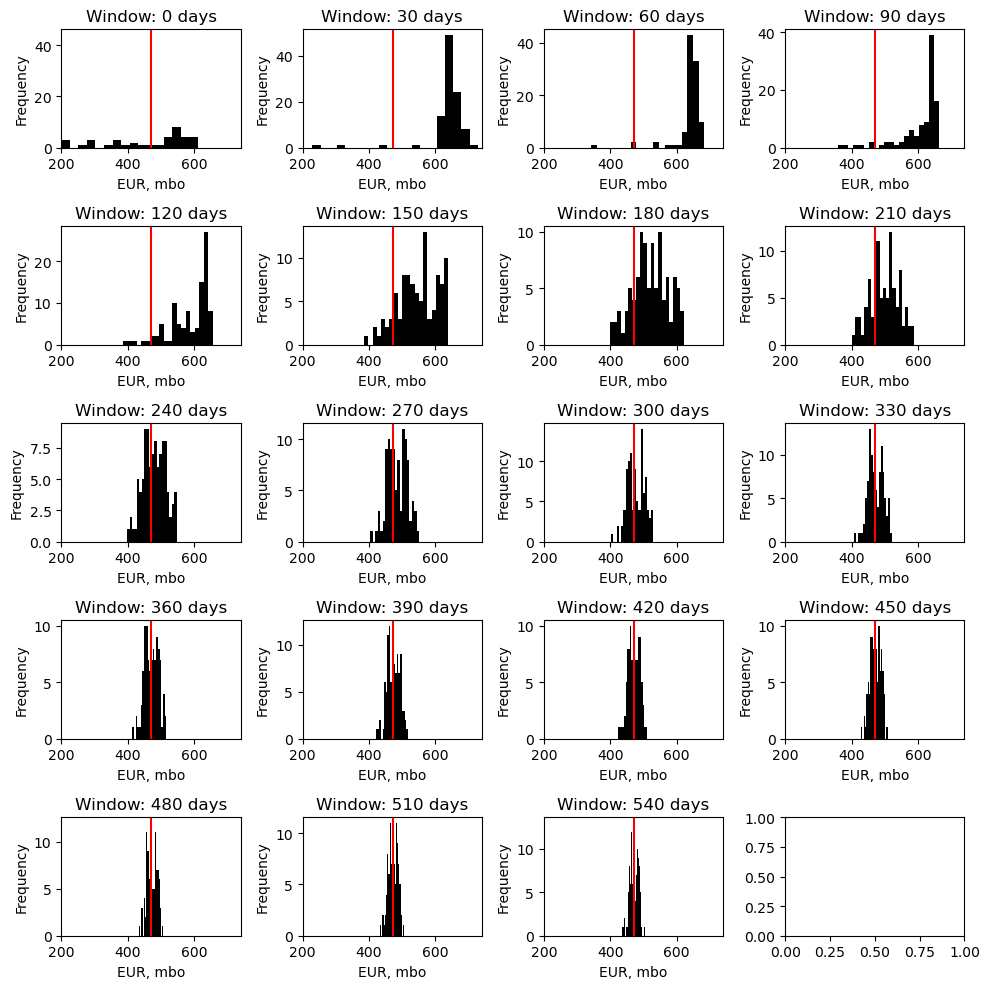

In [9]:
# create histrograms of bootstrapped forecasts for each time window of the test instance
fig, ax = plt.subplots(ncols=4, nrows=5, figsize=(10, 10))
for i in range(0, 19):
    ax[i // 4, i % 4].hist(test.eur_array[:, i]/1000, bins=20, color='k')
    ax[i // 4, i % 4].axvline(test.eur/1000, c='r', label='Ground truth')
    ax[i // 4, i % 4].set(xlim=(200,740), title=f'Window: {i * 30} days', xlabel='EUR, mbo', ylabel='Frequency')

    plt.tight_layout()
plt.tight_layout(); plt.show()

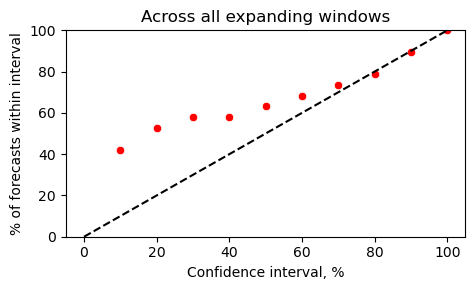

In [83]:
# score the predictions by confidence interval and plot the average score across all expanding windows
test.score_prediction()

fig, ax = plt.subplots(figsize=(golden_ratio * 3, 3))
sns.scatterplot(x=np.array(test.confidence_intervals) * 2, 
                y=np.sum(test.score_array, axis=1) / test.eur_array.shape[1] *100, color='r', ax=ax)
ax.plot((0,100), (0,100), 'k--')
ax.set(title='Across all expanding windows', xlabel='Confidence interval, %', 
       ylabel='% of forecasts within interval', ylim=(0,100))
plt.tight_layout(); plt.show()

In [73]:
# repeat the process for a range of different well forecasts

forecast_parameters = pd.read_excel('Forecast_Input_Parameters.xlsx')
forecast_parameters['eur'] = None
forecast_parameters['well_objects'] = None
forecast_parameters['score'] = None

error = 10
bootstrap_iterations = 100
bootstrap_window = 10
time_increment = 30
max_windows = 12
initial_guess = [0.75, 1.001]
bounds = [(0.5, 0.99), (0.5, 1.5)]
dmin = 0.07
qab = 1

score_array = list()
for i, row in tqdm(forecast_parameters.iterrows(), total=len(forecast_parameters)):
    well = ground_truth(row['qi'], row['di'], row['b'], dmin, qab, 'day')
    well.add_error(error)
    well.bootstrap(iterations=bootstrap_iterations, window=bootstrap_window)
    well.calc_bootsrap_forecasts(time_increments=time_increment, max_windows=max_windows, 
                                 initial=initial_guess, bounds=bounds)
    well.score_prediction()
    forecast_parameters.loc[i, 'eur'] = well.eur
    forecast_parameters.loc[i, 'well_objects'] = well
    score_array.append(well.score_array)

# combine the scoring arrays into one summary score
# [confidence_intervals, time_increments, well_objects]
score_array = np.stack(score_array)

# took 32m to run on my laptop

  0%|          | 0/100 [00:00<?, ?it/s]

In [74]:
# reshape the score array to [time_increments, confidence_intervals, well_objects]
transposed_score_array = np.transpose(score_array, (2,1,0))
# convert the score arrays to a percentage score fore each confidence interval
# output array is [time_increments, pct_score_by_confidence_interval]
percentage_scores = np.sum(np.transpose(score_array, (2,1,0)), axis=2) / transposed_score_array.shape[2]


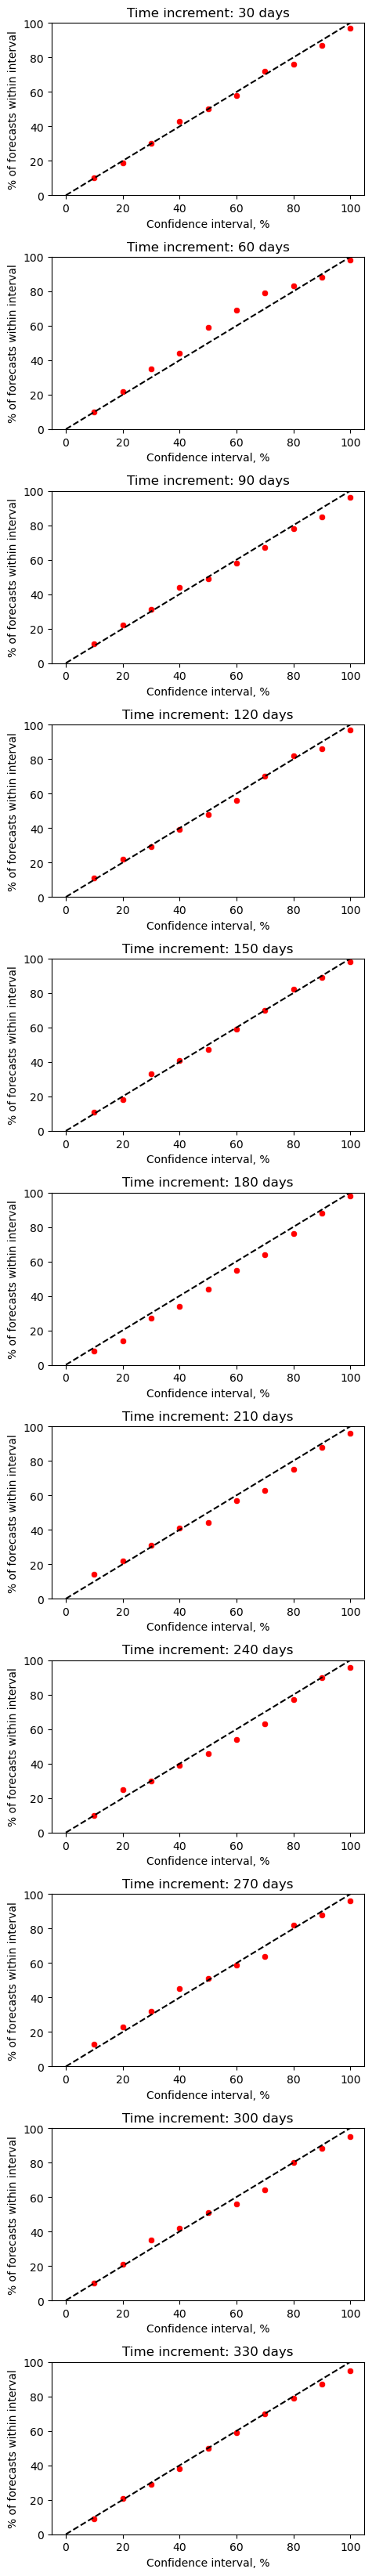

In [81]:
# plot summary scores for each time increment
confidence_intervals = forecast_parameters.well_objects.iloc[0].confidence_intervals

fig, axs = plt.subplots(nrows=max_windows-1, ncols=1, figsize=(golden_ratio * 3, (max_windows-1) * 3))

for i in range(0, max_windows-1):
    sns.scatterplot(x=np.array(confidence_intervals) * 2, y=percentage_scores[i, :] * 100, color='r', ax=axs[i])
    axs[i].plot((0,100), (0,100), 'k--')
    axs[i].set(title=f'Time increment: {(i+1) * time_increment} days', xlabel='Confidence interval, %', 
               ylabel='% of forecasts within interval', ylim=(0,100))
    
plt.tight_layout(); plt.show()